# Predictivity of Latent Variables

In this notebook we will explore how predictivity of latent variables, measured using the metrics of multiple correlation and mutual information, is related to the score of regression models. To run our experiments, we utilize 10 synthetic datasets generated with random non-linear functions applied to Gaussian white noise.

In [1]:
import numpy as np
from sklearn.decomposition import FactorAnalysis, PCA, FastICA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Constants to be used in our code
H_SIZE, X_SIZE, Z_SIZE, N_DATASETS = 2, 4, 2, 10

# List of variables for h, x, and z
h_variables = [f'h_{i}' for i in range(H_SIZE)]
x_variables = [f'x_{i}' for i in range(X_SIZE)]
z_variables = [f'z_{i}' for i in range(Z_SIZE)]

# List of latent methods we are using
methods = [FactorAnalysis, PCA, FastICA, LocallyLinearEmbedding]

# Get latent representations for a given method
def create_latent_space(df, latent_method):
    latent = latent_method(n_components=Z_SIZE, random_state=0).fit_transform(df[x_variables])
    latent = pd.DataFrame(latent, columns=z_variables)
    latent = pd.concat([df, latent], axis=1)
    return latent

# Create dataframes for each method
def get_latent_spaces(df, latent_methods):
    latent_spaces = []
    for latent_method in latent_methods:
        latent = create_latent_space(df, latent_method)
        latent_spaces.append(latent)
    return latent_spaces

# Evaluate the latent space with different regressors
def apply_regressors(latent):

    # List with scores of different regressors
    scores = []

    # Create training and testing sets
    X, y = np.array(latent[z_variables]), np.array(latent['y'].tolist())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

    # Using KNNs for regression
    knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
    scores.append(knn.score(X_train, y_train))

    # Using SVMs for regression
    svm = SVR().fit(X_train, y_train)
    scores.append(svm.score(X_train, y_train))

    # Using random forests for regression
    rfr = RandomForestRegressor(max_depth=5, random_state=0).fit(X_train, y_train)
    scores.append(rfr.score(X_train, y_train))

    # Using linear regression for regression
    lr = LinearRegression().fit(X_train, y_train)
    scores.append(lr.score(X_train, y_train))

    return scores

In [2]:
import pandas as pd
from representation_learning.metrics import multiple_correlation
from sklearn.feature_selection import mutual_info_regression

# Each list will store the results of a method
results = []

# The biggest iteration is going over each dataset
for dataset_i in range(N_DATASETS):

    # Load the dataset and get the latent spaces
    data = pd.read_csv(f'datasets/random_data_{dataset_i}.csv')
    fa, pca, ica, lle = get_latent_spaces(data, methods)

    # Get metrics for each method
    for latent_space in [fa, pca, ica, lle]:
        current_results = [multiple_correlation(latent_space, 'y', z_variables),
                           mutual_info_regression(latent_space[z_variables], latent_space['y']).mean()]
        current_results += apply_regressors(latent_space)
        results.append(current_results)

# Create a pandas DataFrame for results
results = pd.DataFrame(results, columns=['predictivity', 'mutual_info', 'knn_score', 'svm_score', 'rf_score', 'lr_score'])
results.head()

/Users/fernandoassad/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


,predictivity,mutual_info,knn_score,svm_score,rf_score,lr_score
0,0.984083,1.142122,0.993404,0.992630,0.994156,0.984980
1,0.942528,0.558914,0.991025,0.987888,0.990960,0.943670
2,0.942528,0.594601,0.991609,0.989090,0.990084,0.943670
3,0.371549,0.386159,0.689947,0.392006,0.680526,0.347959
4,0.882407,0.498860,0.932079,0.907603,0.949339,0.878806


## Multiple Correlation

In previous experiments, we had found that multiple correlation was not a very good metric to measure the predictivity of non-linear classifiers. It turns out, from our new and more careful experiments, that multiple correlation is actually a good representation of how well the models perform. See plot below.

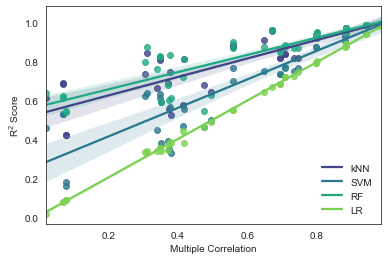

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

for column, color in zip(['knn_score', 'svm_score', 'rf_score', 'lr_score'],
                         sns.color_palette('viridis', 4)):

    sns.regplot(data=results, x='predictivity', y=column, color=color, label=column)

plt.legend(['kNN', 'SVM', 'RF', 'LR'], loc=4, frameon=False)
plt.xlabel('Multiple Correlation')
plt.ylabel('R$^2$ Score')

plt.savefig('figures/predictivity_vs_score.png', dpi=250)
plt.show()

## Mutual Information

Our biggest issue with mutual information is that it is not capable of capturing the mutual information between the entire vector of hidden variables and the labels $y$. For this experiment we average the mutual information of individual latent variables to obtain the final mutual information. Despite the efforts, it seems to be a worse metric than multiple correlation.

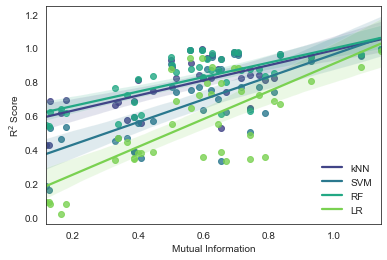

In [4]:
for column, color in zip(['knn_score', 'svm_score', 'rf_score', 'lr_score'],
                         sns.color_palette('viridis', 4)):

    sns.regplot(data=results, x='mutual_info', y=column, color=color, label=column)

plt.legend(['kNN', 'SVM', 'RF', 'LR'], loc=4, frameon=False)
plt.xlabel('Mutual Information')
plt.ylabel('R$^2$ Score')

plt.savefig('figures/mutual_info_vs_score.png', dpi=250)
plt.show()